In [1]:
%pip install --quiet datasets>=2.6.1
%pip install --quiet librosa
%pip install --quiet evaluate>=0.30
%pip install --quiet jiwer/

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: 'jiwer/': Expected end or semicolon (after name and no valid version specifier)
    jiwer/
         ^


In [2]:
%pip install --quiet matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Understanding Dataset

The `load_dataset` takes the extension of the daat and the path to it.
To acces the first element use the command: `atco_asr_data['train'][0]`
The dataset is of type DataDict and has `train` as the only key. However, `train` is of `datasets.arrow_dataset.Dataset` type,and posses the following featurs:
- `audio`: Audio(sampling_rate=None, mono=True, decode=True, id=None)
=> {'path': 'path_to_audio', 'array': array([the_array_numbers], shape=(N_columns,N_lines)), 'sampling_rate': 16000}

*IMPORTANT:* `sampling_rate` should be 16 000 to be identical to Whisper's training dataset, if it is superior to that, we will need to add down sampling.
*IMPORTANT:* The output size is also fixed to 448, aka 30s of audio, if the length of tokens < to 448, the value will be set to -100.
- `text`: Value(dtype='string', id=None)
- `info`: Value(dtype='string', id=None)

In [1]:
from datasets import load_dataset

atco_asr_data = load_dataset('parquet',data_files="dataset/train-00000-of-00005-c6681348ac8543dc.parquet")

c:\Users\cyrine.anene_amaris\Documents\whisper_fine_tuned\Fine-tuning-Whisper-Air-Traffic-Control\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('keys: ')
print(atco_asr_data.keys())
print('train features: ')
print(type(atco_asr_data['train']))
print(atco_asr_data['train'].features)
print('first element train: ')
print(atco_asr_data['train'][0])

keys: 
dict_keys(['train'])
train features: 
<class 'datasets.arrow_dataset.Dataset'>
{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'info': Value(dtype='string', id=None)}
first element train: 
{'audio': {'path': 'LKPR_RUZYNE_Radar_120_520MHz_20201025_091112.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -6.10351562e-05, -6.10351562e-05, -6.10351562e-05], shape=(117760,)), 'sampling_rate': 16000}, 'text': 'Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo ', 'info': 'LKPR\nPraha Ruzyne\nRadar\nAKEVA ARVEG BAGRU BAROX BAVIN BEKVI ELMEK ELPON ERASU EVEMI KENOK KUVIX LETNA RATEV RISUK SOMIS SULOV TIPRU UTORO\nBLA131 BLA1XQ BTI7PY CTN480 DLH3NL DLH9TP ETD72E EWG6HP FIN1DH IRA711 KLM44K MLD863 MLD864 OKHBT OKLLZ OKMHZ OKPHM OKWUS17 OKYAI14 RYR1JU RYR4945 SXS7D THY32B THY6577 TIE790J UAE73  \nAll Charter Air Baltic Croatia Lufthansa Etih

In [3]:
audio_original = atco_asr_data['train'][0]['audio']['array']
original_sample_rate = atco_asr_data['train'][0]['audio']['sampling_rate']

audio_original.shape,original_sample_rate

((117760,), 16000)

In [4]:
from IPython.display import Audio
Audio(audio_original, rate=original_sample_rate)

#### Resampling the audio

In our use case, this step is not needed as we have the original samples equal to 16 000.

In [14]:
from scipy.signal import resample
# Define the target sample rate, identical to the original sample rate from the training
target_sample_rate = 16000

# Calculate the number of samples for the target sample rate
num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

# Resample the audio array to the target sample rate
downsampled_audio = resample(audio_original, num_samples)

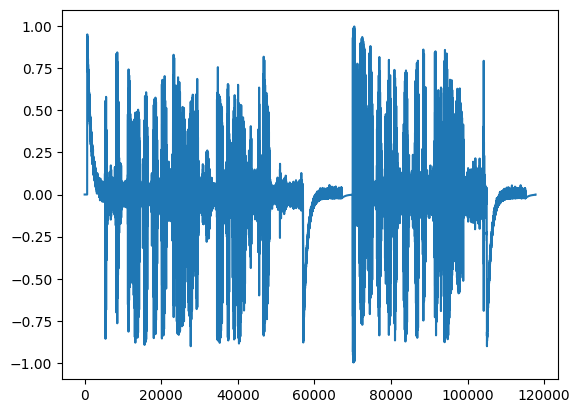

In [15]:
import matplotlib.pyplot as plt
plt.plot(downsampled_audio)

In [16]:
print(downsampled_audio.shape,target_sample_rate)
Audio(downsampled_audio, rate=target_sample_rate)

(117760,) 16000


#### Create target column for Model

In [5]:
target = atco_asr_data['train'][0]['text']
target

'Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo '

In [6]:
from transformers import WhisperTokenizer

#Transcribe the text 
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='english', task='transcribe')
tokenizer_output = tokenizer(target, padding='max_length', max_length=448, truncation=True, return_tensors='pt')

encoded_target = tokenizer_output['input_ids']
attention_mask = tokenizer_output['attention_mask']

encoded_target.shape, attention_mask.shape

(torch.Size([1, 448]), torch.Size([1, 448]))

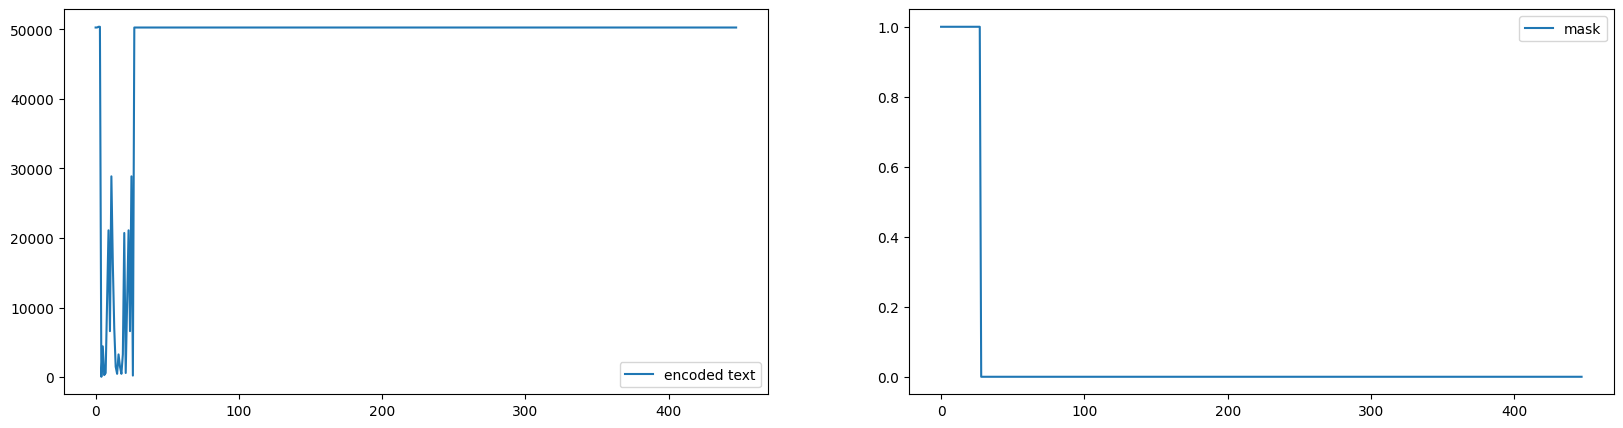

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(encoded_target.reshape(-1,1),label='encoded text')
plt.legend()
plt.subplot(1,2,2)
plt.plot(attention_mask.reshape(-1,1),label='mask')
plt.legend()
plt.show()

In [7]:
encoded_target

tensor([[50258, 50259, 50359, 50363,    46,  4417,   289,   591, 10720, 21102,
          6602, 28861, 16333,  7018,  1496,   472,  3262,  1496,   472,  3262,
         20718,   591, 10720, 21102,  6602, 28861,   220, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 5

The 50257 needs to be changed to -100.

In [10]:
encoded_target = encoded_target.masked_fill(attention_mask.ne(1),-100)

In [11]:
encoded_target

tensor([[50258, 50259, 50359, 50363,    46,  4417,   289,   591, 10720, 21102,
          6602, 28861, 16333,  7018,  1496,   472,  3262,  1496,   472,  3262,
         20718,   591, 10720, 21102,  6602, 28861,   220, 50257,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [12]:
tokenizer.decode(encoded_target[0])

'<|startoftranscript|><|en|><|transcribe|><|notimestamps|>Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo <|endoftext|>'

#### Feature extraction from Input

In [13]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')

c:\Users\cyrine.anene_amaris\Documents\whisper_fine_tuned\Fine-tuning-Whisper-Air-Traffic-Control\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cyrine.anene_amaris\.cache\huggingface\hub\models--openai--whisper-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [17]:
#Pass the downsampled audio to the feature extractor in raw_speech parameter
input_feature = feature_extractor(raw_speech=downsampled_audio,
                                  sampling_rate=16000,
                                  return_tensors='pt').input_features


input_feature.shape

torch.Size([1, 80, 3000])

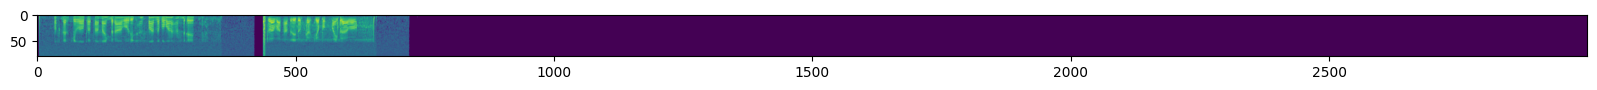

In [18]:
#Plotting the Mel-spectorgram
plt.figure(figsize=(20,20))
plt.imshow(input_feature.squeeze())
plt.show()

The max_length for the Whisper model is 30s, as our data only contains 7s then the rest is padded (technical word for empty).

In [19]:
??feature_extractor

Signature:     
feature_extractor(
    raw_speech: Union[numpy.ndarray, List[float], List[numpy.ndarray], List[List[float]]],
    truncation: bool = True,
    pad_to_multiple_of: Optional[int] = None,
    return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None,
    return_attention_mask: Optional[bool] = None,
    padding: Optional[str] = 'max_length',
    max_length: Optional[int] = None,
    sampling_rate: Optional[int] = None,
    do_normalize: Optional[bool] = None,
    device: Optional[str] = 'cpu',
    return_token_timestamps: Optional[bool] = None,
    **kwargs,
) -> transformers.feature_extraction_utils.BatchFeature
Type:           WhisperFeatureExtractor
String form:   
WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "proc

#### Transcriptions using Model

In [20]:
from transformers import WhisperForConditionalGeneration
import torch

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [21]:
with torch.no_grad():
    op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')


tokenizer.batch_decode(op,skip_special_tokens=False)

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[' Oscar Quilopapa Mike Bravo, RISC100']

In [22]:
with torch.no_grad():
    op = model(input_feature.to('cuda'), labels=encoded_target.to('cuda'))

print(op.loss)
print(op.logits.shape)

activations = torch.nn.functional.softmax(op.logits,dim=-1)
pred_token_ids = torch.argmax(activations,dim=-1)
print(activations.shape, pred_token_ids.shape)

print(tokenizer.batch_decode(pred_token_ids,skip_special_tokens=False))

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


tensor(3.8585, device='cuda:0')
torch.Size([1, 448, 51865])
torch.Size([1, 448, 51865]) torch.Size([1, 448])
['<|cs|><|translate|><|transcribe|><|notimestamps|> Oscarscar,ilo, Mike Bravo, to level 100 hundred<|endoftext|> one hundred O Kilo Papa Mike Bravo<|endoftext|>!!!!<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

#### Performance of model for first five rows

In [23]:
import torch

for idx in range(5):

    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    input_feature = feature_extractor(raw_speech=audio_original,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo  
pred :  Oscar Quilopapa Mike Bravo, RISC100

 
-------1------
true : Oscar Kilo Kilo Echo Alfa Praha Radar identified climb flight level one hundred IFR flight starts  now time zero five cleared to destination via flight plan route  
pred :  Oscar kilo kilo, Eqa, Praha radar identified. Consulate level 100, AFL, now time 05, quick destination, WFL, BenRoot.

 
-------2------
true : Ryanair Seven Three Alpha Hotel turn left heading three six zero Ryanair Seven Three Alpha Hotel  
pred :  Ryanair 730 hotel on left heading 360 Ryanair 730 hotel

 
-------3------
true : Oscar Kilo Kilo Uniform November proceed direct Baltu proceed direct Baltu Oscar Kilo Kilo Uniform November  
pred :  Oscar, what did you say in the phone number?

 
-------4------
true : Oscar Mike Papa turn right heading zero two zero cleared ILS approach runway zero six speed maximum one six ze

#### Fine-tuning

##### A single forward pass

In [24]:
idx=0

target = atco_asr_data['train'][idx]['text']
audio_original = atco_asr_data['train'][idx]['audio']['array']

tokenizer_output = tokenizer(target,padding='max_length',max_length=448,truncation=True,return_tensors='pt')
encoded_target = tokenizer_output['input_ids']
attention_mask = tokenizer_output['attention_mask']
encoded_target = encoded_target.masked_fill(attention_mask.ne(1),-100)

input_feature = feature_extractor(raw_speech=downsampled_audio,
                                  sampling_rate=16000,
                                  return_tensors='pt').input_features

##### A single backward pass and weight update

In [25]:
model.train()  # Set model to training mode
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)

for iter in range(30):

    outputs = model(input_feature.to('cuda'), labels=encoded_target.to('cuda'))  # Assuming your model takes these inputs
    loss = outputs.loss

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()  # Reset gradients

    print(loss.item())

3.8585426807403564
2.629199266433716
1.805428147315979
1.231389045715332
0.8669189214706421
0.6736586689949036
0.5592499375343323
0.49640747904777527
0.4692513048648834
0.4535021185874939
0.4410402774810791
0.4293869137763977
0.41787585616111755
0.4064837396144867
0.3960747718811035
0.3883223235607147
0.3832117021083832
0.3793564736843109
0.37547793984413147
0.3708212077617645
0.3652060627937317
0.35893353819847107
0.3526543080806732
0.34708911180496216
0.34254032373428345
0.3387061655521393
0.3350752890110016
0.33127230405807495
0.3271424472332001
0.3227095901966095


#### Performance of model after 30 steps

In [26]:
model.eval()


for idx in range(5):

    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    input_feature = feature_extractor(raw_speech=audio_original,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n')

-------0------
true : Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo  
pred : Oscar Kilo Papa Mike Bravo descend flight level one hundred level one hundred Oscar Kilo Papa Mike Bravo 


-------1------
true : Oscar Kilo Kilo Echo Alfa Praha Radar identified climb flight level one hundred IFR flight starts  now time zero five cleared to destination via flight plan route  
pred : Oscar Kilo Kilo Eko Alpha Praha Radar identified, con flight level one hundred high flight start now time zero five, good to destination flight flight ban route 


-------2------
true : Ryanair Seven Three Alpha Hotel turn left heading three six zero Ryanair Seven Three Alpha Hotel  
pred : RynaR730 hotel turn left heading 360RynaR730 hotel 


-------3------
true : Oscar Kilo Kilo Uniform November proceed direct Baltu proceed direct Baltu Oscar Kilo Kilo Uniform November  
pred : Oscar Kilo Kilo uniform level proceed direct battle 


-------4------
true : 

In [27]:
??model

Signature:      model(*args, **kwargs)
Type:           WhisperForConditionalGeneration
String form:   
WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_fe

In [28]:
??model.generate

Signature:
model.generate(
    input_features: Optional[torch.Tensor] = None,
    generation_config: Optional[transformers.generation.configuration_utils.GenerationConfig] = None,
    logits_processor: Optional[transformers.generation.logits_process.LogitsProcessorList] = None,
    stopping_criteria: Optional[transformers.generation.stopping_criteria.StoppingCriteriaList] = None,
    prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None,
    synced_gpus: bool = False,
    return_timestamps: Optional[bool] = None,
    task: Optional[str] = None,
    language: Union[List[str], str, NoneType] = None,
    is_multilingual: Optional[bool] = None,
    prompt_ids: Optional[torch.Tensor] = None,
    prompt_condition_type: Optional[str] = None,
    condition_on_prev_tokens: Optional[bool] = None,
    temperature: Union[float, Tuple[float, ...], NoneType] = None,
    compression_ratio_threshold: Optional[float] = None,
    logprob_threshold: Optional[float] = None,
 